In [1]:
import pandas as pd
rway_img_df = pd.read_csv("collection_images_download.csv")
# EXTRACT BRAND FROM IMAGE NAME
rway_img_df['brand'] = rway_img_df['image_name'].str.lower()
rway_img_df['brand'] = rway_img_df['brand'].str.split('couture').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('ready-to-wear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('menswear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.replace("-", " ")
rway_img_df['brand'] = rway_img_df['brand'].str.strip()

# subset rway_img_df where brand cointains versage,hermes
#brand_keywords = ['rick owens', 'louis vuitton', 'versace', 'giorgio armani', 'hermes', 'dries van noten', 'chanel']
brand_keywords = ['rick owens', 'dries van noten','versace', 'louis vuitton','chanel','giorgio armani']

data = rway_img_df[rway_img_df['brand'].isin(brand_keywords)]

# rename brand in target column
data['target'] = data['brand']
# factorized 'brand' using pandas
data['target'] = pd.factorize(data['target'])[0]


/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_36044/3551661527.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['brand']
/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_36044/3551661527.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = pd.factorize(data['target'])[0]


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(
    data['image_path'],
    data['target'],
    test_size=0.2,
    random_state=1234
)

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention

#Define image dimensions (img_height and img_width) to resize the images during preprocessing.
img_height, img_width = 224, 224

# Map the brand labels in y_train and y_val to their corresponding integer labels using the brand_to_label dictionary.
brand_to_label = {brand: i for i, brand in enumerate(np.unique(data['target']))}

# Calculate the number of classes (num_classes) based on the unique labels.
num_classes = len(brand_to_label)

# Define the preprocess_image function to load, resize, and normalize the pixel values of the images.
def preprocess_image(image_path):
    image_path = './imgs/images/images/' + image_path  # Add the path prefix
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = image / 255.0  # Normalize
    return image

print('preprocess imge function defined' )
print('preprocess imge function initialized' )

# Preprocess the images in X_train and X_val by applying the preprocess_image function to each image path.
X_train = np.array([preprocess_image(path) for path in X_train])
X_val = np.array([preprocess_image(path) for path in X_val])

print('preprocess imge function completed' )

preprocess imge function defined
preprocess imge function initialized
preprocess imge function completed


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Multiply, Input, Reshape, Softmax,Conv2D
from tensorflow.keras.models import Model
import numpy as np
import tensorflow as tf
import os
import keras

"""
import pickle
with open('dataset.pkl','rb') as f:
    X_train, X_val, y_train, y_val = pickle.load(f) #the one computed in the previous blocks
    """
# Convert labels to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

In [5]:
X_train = tf.keras.applications.vgg16.preprocess_input(X_train*255)
X_val = tf.keras.applications.vgg16.preprocess_input(X_val*255)

# VGG16 con 100 epoche


In [8]:

img_height = 224
img_width = 224
num_classes=y_val.shape[-1]

# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in base_model.layers:
#     print(layer.name)
    layer.trainable = False

############# augmentation ######################
pre_input = tf.keras.Input((img_height,img_width,3))
pre = tf.keras.layers.RandomFlip("horizontal")(pre_input) # or "horizontal", "vertical"
pre = tf.keras.layers.RandomRotation(0.1)(pre)
pre = tf.keras.layers.RandomTranslation(height_factor=0, width_factor=0.2)(pre)

k = 6 #2 or 6
inp = base_model.layers[-k].output #place attention before the kth last layer

attention = Conv2D(64, (3,3), padding='same',activation='relu')(inp)
# attention = Dense(16, activation='relu')(attention)
attention = Dense(1, activation=None)(attention)
_,attn_h,attn_w,_ = attention.shape
attention = Softmax(axis=[1,2])(0.01*attention) #normalize attention on each image (sums to one)
x = Multiply()([inp, attention])

for layer in base_model.layers[-k+1:]: #attach last k layers
    x = layer(x)
    layer.trainable = False

#classification
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# # Create the model
#during training the input to the modelis the augmented image
model = Model(inputs=pre_input, outputs=Model(inputs=base_model.input, outputs=output)(pre))

# # Compile the model
opt = 'adam'
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

# Train the model
#stops the training when the validation loss does not decrease for more thatn 20 epochs (prevents overfitting)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50) 
history_100 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64,callbacks=[callback], verbose=2)

Epoch 1/100


2023-09-10 19:21:50.963575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 19:21:52.250184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:21:57.043894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:21:58.535176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:21:59.835972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:22:01.098541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10

65/65 - 158s - loss: 1.8398 - accuracy: 0.2960 - val_loss: 1.6187 - val_accuracy: 0.4469 - 158s/epoch - 2s/step
Epoch 2/100


2023-09-10 19:24:26.931332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:24:28.769303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:24:30.670292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:24:32.848541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:24:35.212255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:24:37.361241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 160s - loss: 1.5861 - accuracy: 0.4231 - val_loss: 1.3547 - val_accuracy: 0.5316 - 160s/epoch - 2s/step
Epoch 3/100


2023-09-10 19:27:07.181490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:27:09.236444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:27:11.325978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:27:13.401703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:27:15.454896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:27:17.462927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 155s - loss: 1.3950 - accuracy: 0.4764 - val_loss: 1.3762 - val_accuracy: 0.5453 - 155s/epoch - 2s/step
Epoch 4/100


2023-09-10 19:29:42.293190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:29:44.360186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:29:46.406780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:29:48.419199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:29:50.464527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:29:52.459162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 143s - loss: 1.2819 - accuracy: 0.5377 - val_loss: 1.2073 - val_accuracy: 0.5677 - 143s/epoch - 2s/step
Epoch 5/100


2023-09-10 19:32:04.953299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:32:06.553724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:32:08.116793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:32:09.759588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:32:11.565676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:32:13.448354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 134s - loss: 1.1115 - accuracy: 0.5991 - val_loss: 1.0259 - val_accuracy: 0.6456 - 134s/epoch - 2s/step
Epoch 6/100


2023-09-10 19:34:19.364577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:34:20.927489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:34:22.522449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:34:24.230146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:34:26.034442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:34:27.848182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 133s - loss: 1.0125 - accuracy: 0.6446 - val_loss: 1.0006 - val_accuracy: 0.6709 - 133s/epoch - 2s/step
Epoch 7/100


2023-09-10 19:36:32.594845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:36:34.157818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:36:35.682006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:36:37.265815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:36:38.961204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:36:40.720781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.9217 - accuracy: 0.6855 - val_loss: 0.9939 - val_accuracy: 0.6670 - 132s/epoch - 2s/step
Epoch 8/100


2023-09-10 19:38:44.167372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:38:45.756110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:38:47.286690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:38:48.930254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:38:50.640650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:38:52.407275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 134s - loss: 0.8517 - accuracy: 0.6940 - val_loss: 0.9454 - val_accuracy: 0.7020 - 134s/epoch - 2s/step
Epoch 9/100


2023-09-10 19:40:58.074403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:40:59.679671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:41:01.250769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:41:02.882898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:41:04.622341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:41:06.442361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.8331 - accuracy: 0.7162 - val_loss: 0.7352 - val_accuracy: 0.7731 - 132s/epoch - 2s/step
Epoch 10/100


2023-09-10 19:43:10.168892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:43:11.744860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:43:13.240424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:43:14.791313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:43:16.473278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:43:18.255648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 130s - loss: 0.7154 - accuracy: 0.7578 - val_loss: 0.7058 - val_accuracy: 0.7722 - 130s/epoch - 2s/step
Epoch 11/100


2023-09-10 19:45:20.677794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:45:22.289345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:45:23.883881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:45:25.544721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:45:27.264099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:45:29.004057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 134s - loss: 0.6993 - accuracy: 0.7653 - val_loss: 0.7237 - val_accuracy: 0.7712 - 134s/epoch - 2s/step
Epoch 12/100


2023-09-10 19:47:34.601047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:47:36.181001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:47:37.716921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:47:39.322554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:47:41.115893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:47:42.905858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.6225 - accuracy: 0.7892 - val_loss: 0.6856 - val_accuracy: 0.7731 - 132s/epoch - 2s/step
Epoch 13/100


2023-09-10 19:49:46.312019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:49:47.859585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:49:49.388696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:49:50.992903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:49:52.748622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:49:54.579483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 135s - loss: 0.6083 - accuracy: 0.7907 - val_loss: 0.5945 - val_accuracy: 0.8111 - 135s/epoch - 2s/step
Epoch 14/100


2023-09-10 19:52:00.968369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:52:02.534749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:52:04.071065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:52:05.685697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:52:07.403009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:52:09.184809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 136s - loss: 0.6000 - accuracy: 0.7997 - val_loss: 0.6549 - val_accuracy: 0.7975 - 136s/epoch - 2s/step
Epoch 15/100


2023-09-10 19:54:16.692118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:54:18.249229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:54:19.787011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:54:21.407833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:54:23.187230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:54:25.039862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 135s - loss: 0.5682 - accuracy: 0.8053 - val_loss: 0.7534 - val_accuracy: 0.7848 - 135s/epoch - 2s/step
Epoch 16/100


2023-09-10 19:56:31.950932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:56:33.530605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:56:35.084844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:56:36.790811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:56:38.617386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:56:40.527691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 134s - loss: 0.5693 - accuracy: 0.8028 - val_loss: 0.6617 - val_accuracy: 0.8121 - 134s/epoch - 2s/step
Epoch 17/100


2023-09-10 19:58:46.434057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:58:48.051061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:58:49.645434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:58:51.459403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:58:53.325566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 19:58:55.210676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 137s - loss: 0.4952 - accuracy: 0.8289 - val_loss: 0.6857 - val_accuracy: 0.7975 - 137s/epoch - 2s/step
Epoch 18/100


2023-09-10 20:01:03.196242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:01:04.819195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:01:06.366530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:01:08.067516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:01:09.883798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:01:11.764341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 136s - loss: 0.5151 - accuracy: 0.8396 - val_loss: 0.6822 - val_accuracy: 0.8043 - 136s/epoch - 2s/step
Epoch 19/100


2023-09-10 20:03:19.257499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:03:20.837126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:03:22.439359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:03:24.126558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:03:25.905148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:03:27.742366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 135s - loss: 0.4958 - accuracy: 0.8308 - val_loss: 0.6393 - val_accuracy: 0.8140 - 135s/epoch - 2s/step
Epoch 20/100


2023-09-10 20:05:34.035422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:05:35.620917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:05:37.137933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:05:38.737410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:05:40.458057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:05:42.242221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 135s - loss: 0.4826 - accuracy: 0.8340 - val_loss: 0.5879 - val_accuracy: 0.8277 - 135s/epoch - 2s/step
Epoch 21/100


2023-09-10 20:07:48.973429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:07:50.595930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:07:52.221913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:07:54.016514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:07:55.833986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:07:57.688688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 136s - loss: 0.4597 - accuracy: 0.8469 - val_loss: 0.4994 - val_accuracy: 0.8393 - 136s/epoch - 2s/step
Epoch 22/100


2023-09-10 20:10:05.096876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:10:06.678587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:10:08.224263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:10:09.847959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:10:11.598432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:10:13.455213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 137s - loss: 0.4217 - accuracy: 0.8532 - val_loss: 0.7493 - val_accuracy: 0.7975 - 137s/epoch - 2s/step
Epoch 23/100


2023-09-10 20:12:22.396648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:12:24.104404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:12:25.874667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:12:27.693961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:12:29.530567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:12:31.356945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 137s - loss: 0.4481 - accuracy: 0.8513 - val_loss: 0.6419 - val_accuracy: 0.8247 - 137s/epoch - 2s/step
Epoch 24/100


2023-09-10 20:14:39.717181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:14:41.317867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:14:42.895645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:14:44.529151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:14:46.243944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:14:48.026545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 136s - loss: 0.4054 - accuracy: 0.8656 - val_loss: 0.5735 - val_accuracy: 0.8403 - 136s/epoch - 2s/step
Epoch 25/100


2023-09-10 20:16:55.933783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:16:57.546549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:16:59.100326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:17:00.717682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:17:02.435965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:17:04.212746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 136s - loss: 0.3823 - accuracy: 0.8644 - val_loss: 0.5259 - val_accuracy: 0.8296 - 136s/epoch - 2s/step
Epoch 26/100


2023-09-10 20:19:11.532329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:19:13.087047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:19:14.642031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:19:16.218236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:19:17.898579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:19:19.674323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 136s - loss: 0.3893 - accuracy: 0.8666 - val_loss: 0.6704 - val_accuracy: 0.8179 - 136s/epoch - 2s/step
Epoch 27/100


2023-09-10 20:21:27.412712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:21:29.016964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:21:30.605266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:21:32.313415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:21:34.176261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:21:36.016666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 136s - loss: 0.4732 - accuracy: 0.8578 - val_loss: 0.5659 - val_accuracy: 0.8423 - 136s/epoch - 2s/step
Epoch 28/100


2023-09-10 20:23:43.208474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:23:44.774899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:23:46.305664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:23:47.951413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:23:49.735392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:23:51.678738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 136s - loss: 0.3985 - accuracy: 0.8705 - val_loss: 0.5933 - val_accuracy: 0.8228 - 136s/epoch - 2s/step
Epoch 29/100


2023-09-10 20:25:58.788351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:26:00.379752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:26:01.929363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:26:03.564566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:26:05.329701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:26:07.224691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 134s - loss: 0.3898 - accuracy: 0.8703 - val_loss: 0.5421 - val_accuracy: 0.8403 - 134s/epoch - 2s/step
Epoch 30/100


2023-09-10 20:28:13.105548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:28:14.677211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:28:16.205803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:28:17.821676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:28:19.580394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:28:21.436017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 136s - loss: 0.3628 - accuracy: 0.8761 - val_loss: 0.5721 - val_accuracy: 0.8267 - 136s/epoch - 2s/step
Epoch 31/100


2023-09-10 20:30:28.818913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:30:30.419805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:30:31.956622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:30:33.563147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:30:35.305703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:30:37.140398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 135s - loss: 0.4020 - accuracy: 0.8729 - val_loss: 0.6192 - val_accuracy: 0.8306 - 135s/epoch - 2s/step
Epoch 32/100


2023-09-10 20:32:43.795833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:32:45.352809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:32:46.884118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:32:48.452705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:32:50.176279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:32:52.000656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 134s - loss: 0.4391 - accuracy: 0.8564 - val_loss: 0.6408 - val_accuracy: 0.8218 - 134s/epoch - 2s/step
Epoch 33/100


2023-09-10 20:34:57.451527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:34:59.028550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:35:00.547830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:35:02.143953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:35:03.871768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:35:05.696813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 135s - loss: 0.4182 - accuracy: 0.8698 - val_loss: 0.4399 - val_accuracy: 0.8685 - 135s/epoch - 2s/step
Epoch 34/100


2023-09-10 20:37:12.141496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:37:13.699303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:37:15.236777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:37:16.870964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:37:18.627136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:37:20.476042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 135s - loss: 0.3826 - accuracy: 0.8834 - val_loss: 0.6339 - val_accuracy: 0.8228 - 135s/epoch - 2s/step
Epoch 35/100


2023-09-10 20:39:27.164882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:39:28.722470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:39:30.231062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:39:31.816084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:39:33.510923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:39:35.295725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 134s - loss: 0.4331 - accuracy: 0.8595 - val_loss: 0.5352 - val_accuracy: 0.8364 - 134s/epoch - 2s/step
Epoch 36/100


2023-09-10 20:41:41.204457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:41:42.776071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:41:44.309648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:41:45.928889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:41:47.651394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:41:49.463195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.3840 - accuracy: 0.8793 - val_loss: 0.6388 - val_accuracy: 0.8413 - 132s/epoch - 2s/step
Epoch 37/100


2023-09-10 20:43:53.036364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:43:54.694967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:43:56.306103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:43:57.980360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:43:59.729440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:44:01.503430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 133s - loss: 0.3772 - accuracy: 0.8710 - val_loss: 0.4597 - val_accuracy: 0.8598 - 133s/epoch - 2s/step
Epoch 38/100


2023-09-10 20:46:06.108464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:46:07.700351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:46:09.263779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:46:10.913263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:46:12.624583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:46:14.372905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.3709 - accuracy: 0.8822 - val_loss: 0.5277 - val_accuracy: 0.8539 - 132s/epoch - 2s/step
Epoch 39/100


2023-09-10 20:48:18.201878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:48:19.813749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:48:21.423355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:48:23.152958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:48:24.914440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:48:26.668643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 130s - loss: 0.3947 - accuracy: 0.8717 - val_loss: 0.5888 - val_accuracy: 0.8364 - 130s/epoch - 2s/step
Epoch 40/100


2023-09-10 20:50:28.322070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:50:29.873289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:50:31.359179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:50:32.920825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:50:34.587362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:50:36.377689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 131s - loss: 0.3612 - accuracy: 0.8858 - val_loss: 0.5387 - val_accuracy: 0.8578 - 131s/epoch - 2s/step
Epoch 41/100


2023-09-10 20:52:39.708155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:52:41.348464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:52:43.022966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:52:44.787666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:52:46.572205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:52:48.325851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.3719 - accuracy: 0.8873 - val_loss: 0.6249 - val_accuracy: 0.8452 - 132s/epoch - 2s/step
Epoch 42/100


2023-09-10 20:54:51.271489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:54:52.831009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:54:54.340613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:54:55.918706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:54:57.568746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:54:59.303587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.3275 - accuracy: 0.8953 - val_loss: 0.4490 - val_accuracy: 0.8754 - 132s/epoch - 2s/step
Epoch 43/100


2023-09-10 20:57:03.458093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:57:05.001346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:57:06.517196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:57:08.075203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:57:09.752386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:57:11.467486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 130s - loss: 0.3247 - accuracy: 0.8926 - val_loss: 0.4740 - val_accuracy: 0.8705 - 130s/epoch - 2s/step
Epoch 44/100


2023-09-10 20:59:13.905833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:59:15.474449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:59:16.993854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:59:18.619441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:59:20.257330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 20:59:22.010464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 131s - loss: 0.3580 - accuracy: 0.8934 - val_loss: 0.4595 - val_accuracy: 0.8676 - 131s/epoch - 2s/step
Epoch 45/100


2023-09-10 21:01:25.229178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:01:26.793624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:01:28.289716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:01:29.852885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:01:31.465531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:01:33.147046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.2966 - accuracy: 0.9026 - val_loss: 0.5477 - val_accuracy: 0.8520 - 132s/epoch - 2s/step
Epoch 46/100


2023-09-10 21:03:36.751674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:03:38.359869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:03:39.941898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:03:41.632417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:03:43.375443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:03:45.131363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 133s - loss: 0.3080 - accuracy: 0.9017 - val_loss: 0.5251 - val_accuracy: 0.8569 - 133s/epoch - 2s/step
Epoch 47/100


2023-09-10 21:05:49.754512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:05:51.340565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:05:52.893413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:05:54.573732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:05:56.326174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:05:58.137018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 133s - loss: 0.3084 - accuracy: 0.9021 - val_loss: 0.6769 - val_accuracy: 0.8257 - 133s/epoch - 2s/step
Epoch 48/100


2023-09-10 21:08:02.398501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:08:03.969138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:08:05.464531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:08:07.111675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:08:08.752501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:08:10.466169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 130s - loss: 0.3351 - accuracy: 0.8965 - val_loss: 0.4890 - val_accuracy: 0.8569 - 130s/epoch - 2s/step
Epoch 49/100


2023-09-10 21:10:12.470119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:10:14.006349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:10:15.495508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:10:17.057921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:10:18.675872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:10:20.365187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 131s - loss: 0.3259 - accuracy: 0.8980 - val_loss: 0.4967 - val_accuracy: 0.8705 - 131s/epoch - 2s/step
Epoch 50/100


2023-09-10 21:12:23.168891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:12:24.735769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:12:26.236734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:12:27.809187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:12:29.433586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:12:31.115507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 128s - loss: 0.3512 - accuracy: 0.8939 - val_loss: 0.6448 - val_accuracy: 0.8325 - 128s/epoch - 2s/step
Epoch 51/100


2023-09-10 21:14:31.456374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:14:33.043069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:14:34.586181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:14:36.221149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:14:37.913971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:14:39.661856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 129s - loss: 0.3553 - accuracy: 0.8939 - val_loss: 0.5995 - val_accuracy: 0.8471 - 129s/epoch - 2s/step
Epoch 52/100


2023-09-10 21:16:40.582562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:16:42.145868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:16:43.641279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:16:45.208834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:16:46.826314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:16:48.517267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 129s - loss: 0.3265 - accuracy: 0.8987 - val_loss: 0.5460 - val_accuracy: 0.8549 - 129s/epoch - 2s/step
Epoch 53/100


2023-09-10 21:18:49.470184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:18:50.999738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:18:52.501419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:18:54.088641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:18:55.770591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:18:57.598272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 129s - loss: 0.3225 - accuracy: 0.9000 - val_loss: 0.5065 - val_accuracy: 0.8773 - 129s/epoch - 2s/step
Epoch 54/100


2023-09-10 21:20:58.558261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:21:00.135386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:21:01.601264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:21:03.134129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:21:04.756816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:21:06.446658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 129s - loss: 0.3410 - accuracy: 0.9000 - val_loss: 0.5298 - val_accuracy: 0.8608 - 129s/epoch - 2s/step
Epoch 55/100


2023-09-10 21:23:07.684655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:23:09.233321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:23:10.713824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:23:12.248437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:23:13.849806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:23:15.527434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 129s - loss: 0.3531 - accuracy: 0.8931 - val_loss: 0.5212 - val_accuracy: 0.8705 - 129s/epoch - 2s/step
Epoch 56/100


2023-09-10 21:25:16.856992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:25:18.367843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:25:19.848867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:25:21.391542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:25:23.009722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:25:24.701289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 130s - loss: 0.3012 - accuracy: 0.9056 - val_loss: 0.5368 - val_accuracy: 0.8569 - 130s/epoch - 2s/step
Epoch 57/100


2023-09-10 21:27:26.864780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:27:28.413585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:27:29.902357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:27:31.457239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:27:33.094504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:27:34.885731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 131s - loss: 0.3396 - accuracy: 0.8951 - val_loss: 0.6912 - val_accuracy: 0.8140 - 131s/epoch - 2s/step
Epoch 58/100


2023-09-10 21:29:37.952115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:29:39.517815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:29:41.004981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:29:42.542264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:29:44.164619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:29:45.866397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 130s - loss: 0.3318 - accuracy: 0.9063 - val_loss: 0.6815 - val_accuracy: 0.8374 - 130s/epoch - 2s/step
Epoch 59/100


2023-09-10 21:31:48.215842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:31:49.787378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:31:51.292292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:31:52.874270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:31:54.646031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:31:56.404502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 131s - loss: 0.3139 - accuracy: 0.9102 - val_loss: 0.4990 - val_accuracy: 0.8715 - 131s/epoch - 2s/step
Epoch 60/100


2023-09-10 21:33:58.735634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:34:00.302198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:34:01.860035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:34:03.402323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:34:05.069862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:34:06.831132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.3630 - accuracy: 0.8853 - val_loss: 0.6229 - val_accuracy: 0.8442 - 132s/epoch - 2s/step
Epoch 61/100


2023-09-10 21:36:10.839879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:36:12.441588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:36:13.994162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:36:15.579475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:36:17.275001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:36:19.018155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.4360 - accuracy: 0.8836 - val_loss: 0.6123 - val_accuracy: 0.8500 - 132s/epoch - 2s/step
Epoch 62/100


2023-09-10 21:38:23.207276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:38:24.801917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:38:26.345023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:38:27.930692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:38:29.630310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:38:31.378826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 133s - loss: 0.3739 - accuracy: 0.8995 - val_loss: 0.5722 - val_accuracy: 0.8510 - 133s/epoch - 2s/step
Epoch 63/100


2023-09-10 21:40:36.506576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:40:38.106931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:40:39.634130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:40:41.219974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:40:42.907601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:40:44.666488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.3115 - accuracy: 0.9029 - val_loss: 0.5484 - val_accuracy: 0.8656 - 132s/epoch - 2s/step
Epoch 64/100


2023-09-10 21:42:48.529058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:42:50.103188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:42:51.633182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:42:53.257136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:42:55.098466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:42:57.044616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 134s - loss: 0.3047 - accuracy: 0.9043 - val_loss: 0.5349 - val_accuracy: 0.8724 - 134s/epoch - 2s/step
Epoch 65/100


2023-09-10 21:45:03.021786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:45:04.569314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:45:06.076704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:45:07.648522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:45:09.323717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:45:11.097595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.3432 - accuracy: 0.8992 - val_loss: 0.4305 - val_accuracy: 0.8841 - 132s/epoch - 2s/step
Epoch 66/100


2023-09-10 21:47:15.312468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:47:16.867775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:47:18.373382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:47:19.971395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:47:21.641874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:47:23.432133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 135s - loss: 0.2999 - accuracy: 0.9056 - val_loss: 0.5052 - val_accuracy: 0.8802 - 135s/epoch - 2s/step
Epoch 67/100


2023-09-10 21:49:29.914698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:49:31.587443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:49:33.172389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:49:34.855010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:49:36.614394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:49:38.425569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 134s - loss: 0.3834 - accuracy: 0.8946 - val_loss: 0.6296 - val_accuracy: 0.8423 - 134s/epoch - 2s/step
Epoch 68/100


2023-09-10 21:51:43.586777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:51:45.118875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:51:46.613185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:51:48.178370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:51:49.839399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:51:51.633181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 132s - loss: 0.3129 - accuracy: 0.9019 - val_loss: 0.6728 - val_accuracy: 0.8286 - 132s/epoch - 2s/step
Epoch 69/100


2023-09-10 21:53:55.769018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:53:57.472775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:53:59.160623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:54:00.845626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:54:02.580399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:54:04.351643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 135s - loss: 0.4033 - accuracy: 0.8870 - val_loss: 0.6043 - val_accuracy: 0.8510 - 135s/epoch - 2s/step
Epoch 70/100


2023-09-10 21:56:10.299971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:56:11.983452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:56:13.611507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:56:15.293443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:56:17.045933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:56:18.822055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 135s - loss: 0.3184 - accuracy: 0.9056 - val_loss: 0.5325 - val_accuracy: 0.8793 - 135s/epoch - 2s/step
Epoch 71/100


2023-09-10 21:58:24.904543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:58:26.501634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:58:28.074656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:58:29.712689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:58:31.464048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 21:58:33.310312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 135s - loss: 0.3749 - accuracy: 0.9036 - val_loss: 0.7142 - val_accuracy: 0.8588 - 135s/epoch - 2s/step
Epoch 72/100


2023-09-10 22:00:39.644358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:00:41.211492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:00:42.735605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:00:44.328856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:00:46.029948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:00:47.852324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 136s - loss: 0.3639 - accuracy: 0.9094 - val_loss: 0.5128 - val_accuracy: 0.8656 - 136s/epoch - 2s/step
Epoch 73/100


2023-09-10 22:02:55.761380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:02:57.376702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:02:58.920320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:03:00.627151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:03:02.345798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:03:04.185549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 134s - loss: 0.3446 - accuracy: 0.8934 - val_loss: 0.5129 - val_accuracy: 0.8685 - 134s/epoch - 2s/step
Epoch 74/100


2023-09-10 22:05:09.489848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:05:11.045349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:05:12.527584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:05:14.088342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:05:15.743048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:05:17.482019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 129s - loss: 0.4039 - accuracy: 0.8914 - val_loss: 0.4922 - val_accuracy: 0.8822 - 129s/epoch - 2s/step
Epoch 75/100


2023-09-10 22:07:18.753615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:07:20.305869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:07:21.804348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:07:23.387371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:07:25.082276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:07:26.876933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 129s - loss: 0.3113 - accuracy: 0.9070 - val_loss: 0.4380 - val_accuracy: 0.8724 - 129s/epoch - 2s/step
Epoch 76/100


2023-09-10 22:09:28.190540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:09:29.694140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:09:31.177338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:09:32.687414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:09:34.281432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:09:35.976866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 126s - loss: 0.2786 - accuracy: 0.9131 - val_loss: 0.4050 - val_accuracy: 0.8851 - 126s/epoch - 2s/step
Epoch 77/100


2023-09-10 22:11:33.735128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:11:35.290887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:11:36.761614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:11:38.282413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:11:39.841098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:11:41.447858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 119s - loss: 0.3304 - accuracy: 0.9099 - val_loss: 0.4605 - val_accuracy: 0.8900 - 119s/epoch - 2s/step
Epoch 78/100


2023-09-10 22:13:32.677089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:13:34.105531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:13:35.472789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:13:36.880488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:13:38.369713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:13:39.806676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 114s - loss: 0.2959 - accuracy: 0.9167 - val_loss: 0.4266 - val_accuracy: 0.8870 - 114s/epoch - 2s/step
Epoch 79/100


2023-09-10 22:15:26.835509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:15:28.318778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:15:29.815523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:15:31.467488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:15:33.284962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:15:35.182855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 120s - loss: 0.3356 - accuracy: 0.9102 - val_loss: 0.6137 - val_accuracy: 0.8384 - 120s/epoch - 2s/step
Epoch 80/100


2023-09-10 22:17:27.207883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:17:28.715931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:17:30.128530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:17:31.566824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:17:33.022464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:17:34.592809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 118s - loss: 0.2796 - accuracy: 0.9160 - val_loss: 0.3858 - val_accuracy: 0.9036 - 118s/epoch - 2s/step
Epoch 81/100


2023-09-10 22:19:25.522174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:19:26.975845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:19:28.377975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:19:29.827345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:19:31.300342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:19:32.845616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 121s - loss: 0.2794 - accuracy: 0.9206 - val_loss: 0.4476 - val_accuracy: 0.8783 - 121s/epoch - 2s/step
Epoch 82/100


2023-09-10 22:21:26.673266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:21:28.079216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:21:29.458998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:21:30.889521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:21:32.288865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:21:33.729820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 122s - loss: 0.3090 - accuracy: 0.9094 - val_loss: 0.5486 - val_accuracy: 0.8685 - 122s/epoch - 2s/step
Epoch 83/100


2023-09-10 22:23:28.522871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:23:30.113479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:23:31.566698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:23:33.017082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:23:34.463878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:23:35.943002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 121s - loss: 0.3291 - accuracy: 0.9070 - val_loss: 0.6539 - val_accuracy: 0.8277 - 121s/epoch - 2s/step
Epoch 84/100


2023-09-10 22:25:29.955468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:25:31.443384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:25:32.816922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:25:34.227998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:25:35.670897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:25:37.149382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 121s - loss: 0.4192 - accuracy: 0.8858 - val_loss: 0.5210 - val_accuracy: 0.8500 - 121s/epoch - 2s/step
Epoch 85/100


2023-09-10 22:27:31.416066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:27:32.889085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:27:34.259202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:27:35.730603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:27:37.314039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:27:38.891185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 125s - loss: 0.3286 - accuracy: 0.9131 - val_loss: 0.6186 - val_accuracy: 0.8559 - 125s/epoch - 2s/step
Epoch 86/100


2023-09-10 22:29:36.608588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:29:38.277977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:29:39.831530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:29:41.369428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:29:42.937845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:29:44.503763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 123s - loss: 0.3755 - accuracy: 0.8961 - val_loss: 0.5824 - val_accuracy: 0.8530 - 123s/epoch - 2s/step
Epoch 87/100


2023-09-10 22:31:39.784895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:31:41.267088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:31:42.734011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:31:44.209630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:31:45.724402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:31:47.300423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 125s - loss: 0.3150 - accuracy: 0.9143 - val_loss: 0.4970 - val_accuracy: 0.8695 - 125s/epoch - 2s/step
Epoch 88/100


2023-09-10 22:33:44.440199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:33:45.852744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:33:47.319267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:33:48.717472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:33:50.198884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:33:51.730740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 125s - loss: 0.2506 - accuracy: 0.9180 - val_loss: 0.5724 - val_accuracy: 0.8617 - 125s/epoch - 2s/step
Epoch 89/100


2023-09-10 22:35:49.721386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:35:51.151074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:35:52.582750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:35:54.050829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:35:55.513482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:35:57.068699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 125s - loss: 0.3362 - accuracy: 0.9129 - val_loss: 0.6421 - val_accuracy: 0.8754 - 125s/epoch - 2s/step
Epoch 90/100


2023-09-10 22:37:54.482164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:37:56.061096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:37:57.567913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:37:59.105609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:38:00.748776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:38:02.382854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 125s - loss: 0.4372 - accuracy: 0.8953 - val_loss: 0.8189 - val_accuracy: 0.8306 - 125s/epoch - 2s/step
Epoch 91/100


2023-09-10 22:39:59.989445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:40:01.464109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:40:02.851229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:40:04.231002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:40:05.678838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:40:07.175353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 124s - loss: 0.3432 - accuracy: 0.9034 - val_loss: 0.6460 - val_accuracy: 0.8500 - 124s/epoch - 2s/step
Epoch 92/100


2023-09-10 22:42:04.505309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:42:06.026925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:42:07.449509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:42:08.897830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:42:10.370639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:42:11.931738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 124s - loss: 0.3466 - accuracy: 0.9187 - val_loss: 0.7779 - val_accuracy: 0.8423 - 124s/epoch - 2s/step
Epoch 93/100


2023-09-10 22:44:08.777778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:44:10.239842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:44:11.624781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:44:13.043348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:44:14.472819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:44:15.948408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 124s - loss: 0.3663 - accuracy: 0.9053 - val_loss: 0.4512 - val_accuracy: 0.8793 - 124s/epoch - 2s/step
Epoch 94/100


2023-09-10 22:46:12.422060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:46:13.935610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:46:15.326563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:46:16.769587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:46:18.281602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:46:19.793372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 123s - loss: 0.3125 - accuracy: 0.9167 - val_loss: 0.5753 - val_accuracy: 0.8724 - 123s/epoch - 2s/step
Epoch 95/100


2023-09-10 22:48:15.027348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:48:16.503956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:48:17.907008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:48:19.386532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:48:20.967188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:48:22.600912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 124s - loss: 0.3583 - accuracy: 0.9029 - val_loss: 0.5631 - val_accuracy: 0.8637 - 124s/epoch - 2s/step
Epoch 96/100


2023-09-10 22:50:18.631891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:50:20.078844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:50:21.512438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:50:22.974313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:50:24.482203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:50:26.067427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 125s - loss: 0.2864 - accuracy: 0.9129 - val_loss: 0.5851 - val_accuracy: 0.8627 - 125s/epoch - 2s/step
Epoch 97/100


2023-09-10 22:52:23.427521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:52:24.912062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:52:26.334022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:52:27.808452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:52:29.401756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:52:31.002060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 127s - loss: 0.3209 - accuracy: 0.9082 - val_loss: 0.7265 - val_accuracy: 0.8345 - 127s/epoch - 2s/step
Epoch 98/100


2023-09-10 22:54:30.083012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:54:31.543519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:54:33.167772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:54:34.823378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:54:36.352790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:54:37.862107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 120s - loss: 0.3405 - accuracy: 0.9002 - val_loss: 0.6157 - val_accuracy: 0.8578 - 120s/epoch - 2s/step
Epoch 99/100


2023-09-10 22:56:30.091512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:56:31.483182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:56:32.889200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:56:34.295200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:56:35.720027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:56:37.391656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 119s - loss: 0.3732 - accuracy: 0.9009 - val_loss: 0.6087 - val_accuracy: 0.8656 - 119s/epoch - 2s/step
Epoch 100/100


2023-09-10 22:58:29.132586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:58:30.588496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:58:31.968379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:58:33.334410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:58:34.790260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-10 22:58:36.323243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

65/65 - 122s - loss: 0.3837 - accuracy: 0.9026 - val_loss: 0.6901 - val_accuracy: 0.8588 - 122s/epoch - 2s/step


In [14]:
from tensorflow.keras.models import load_model

model.save('./image_classification_model_withbkg.h5')
image_classification_model_withbkg_h5 = load_model('image_classification_model_withbkg.h5')

#----------------------------------------------------------------------
import json
history_dict = {
    'loss': history_100.history['loss'],
    'val_loss': history_100.history['val_loss'],
    'accuracy': history_100.history['accuracy'],
    'val_accuracy': history_100.history['val_accuracy']
}

#----------------------------------------------------------------------
# Save the history dictionary as a JSON file
with open('image_classification_model_withbkg.json', 'w') as json_file:
    json.dump(history_dict, json_file)
with open('image_classification_model_withbkg.json', 'r') as json_file:
    image_classification_model_withbkg_json = json.load(json_file)

#  Graph

In [87]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 random_translation_2 (Rand  (None, 224, 224, 3)       0         
 omTranslation)                                                  
                                                                 
 model_4 (Functional)        (None, 6)                 15275463  
                                                                 
Total params: 15275463 (58.27 MB)
Trainable params: 560775 

In [70]:
# Stampa un riepilogo delle informazioni sui layer nel model_4
model.get_layer('model_4').summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [71]:
with open('model_4_summary.txt', 'w') as f:
    model.get_layer('model_4').summary(print_fn=lambda x: f.write(x + '\n'))


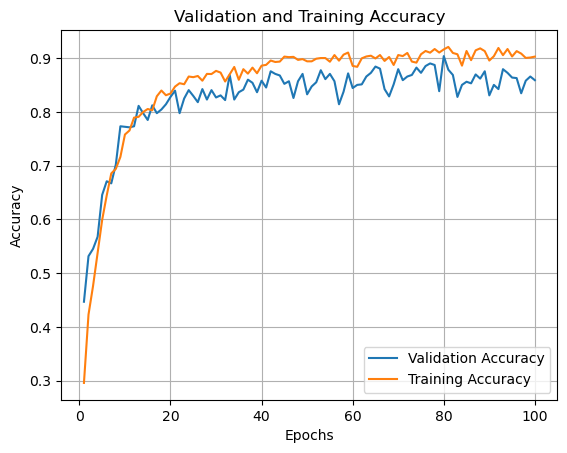

In [28]:
import matplotlib.pyplot as plt
val_accuracy = image_classification_model_withbkg_json['val_accuracy']
accuracy = image_classification_model_withbkg_json['accuracy']
epochs = range(1, len(val_accuracy) + 1)


plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


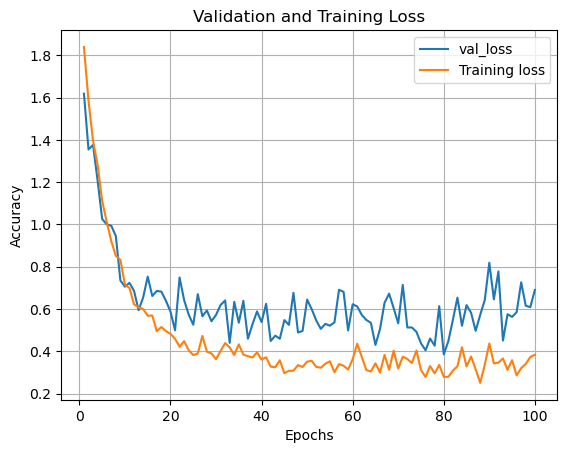

In [27]:
val_accuracy = image_classification_model_withbkg_json['val_loss']
accuracy = image_classification_model_withbkg_json['loss']
epochs = range(1, len(val_accuracy) + 1)

plt.plot(epochs, val_accuracy, label='val_loss')
plt.plot(epochs, accuracy, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Loss')
plt.legend()
plt.grid(True)
plt.show()


In [94]:
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['rick owens', 'dries van noten','versace', 'louis vuitton','chanel','giorgio armani']

# Calcola le previsioni del modello sul set di dati di validazione
y_pred = model.predict(X_val)

# Converte le previsioni in etichette di classe
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)  # Assumendo che y_val sia one-hot encoded

# Calcola la matrice di confusione
confusion = confusion_matrix(y_val_classes, y_pred_classes)

# Calcola precision, recall e F1-score per ogni classe
report = classification_report(y_val_classes, y_pred_classes, target_names=class_names)

# Visualizza la matrice di confusione
print("Confusion Matrix:")
print(confusion)

# Visualizza il report di classificazione
print("Classification Report:")
print(report)


33/33 [==============================] - 16s 468ms/step
Confusion Matrix:
[[143   6   9   1   0   2]
 [  5 148  10   5   3   3]
 [ 16   4 156   5   3   5]
 [  5   7   9 152   4   2]
 [  3   1   2   0 153   1]
 [  5   2  18   1   8 130]]
Classification Report:
                 precision    recall  f1-score   support

     rick owens       0.81      0.89      0.85       161
dries van noten       0.88      0.85      0.87       174
        versace       0.76      0.83      0.79       189
  louis vuitton       0.93      0.85      0.89       179
         chanel       0.89      0.96      0.92       160
 giorgio armani       0.91      0.79      0.85       164

       accuracy                           0.86      1027
      macro avg       0.86      0.86      0.86      1027
   weighted avg       0.86      0.86      0.86      1027



Layers di 'model' (model):
Layers di 'model_4' (model_4):


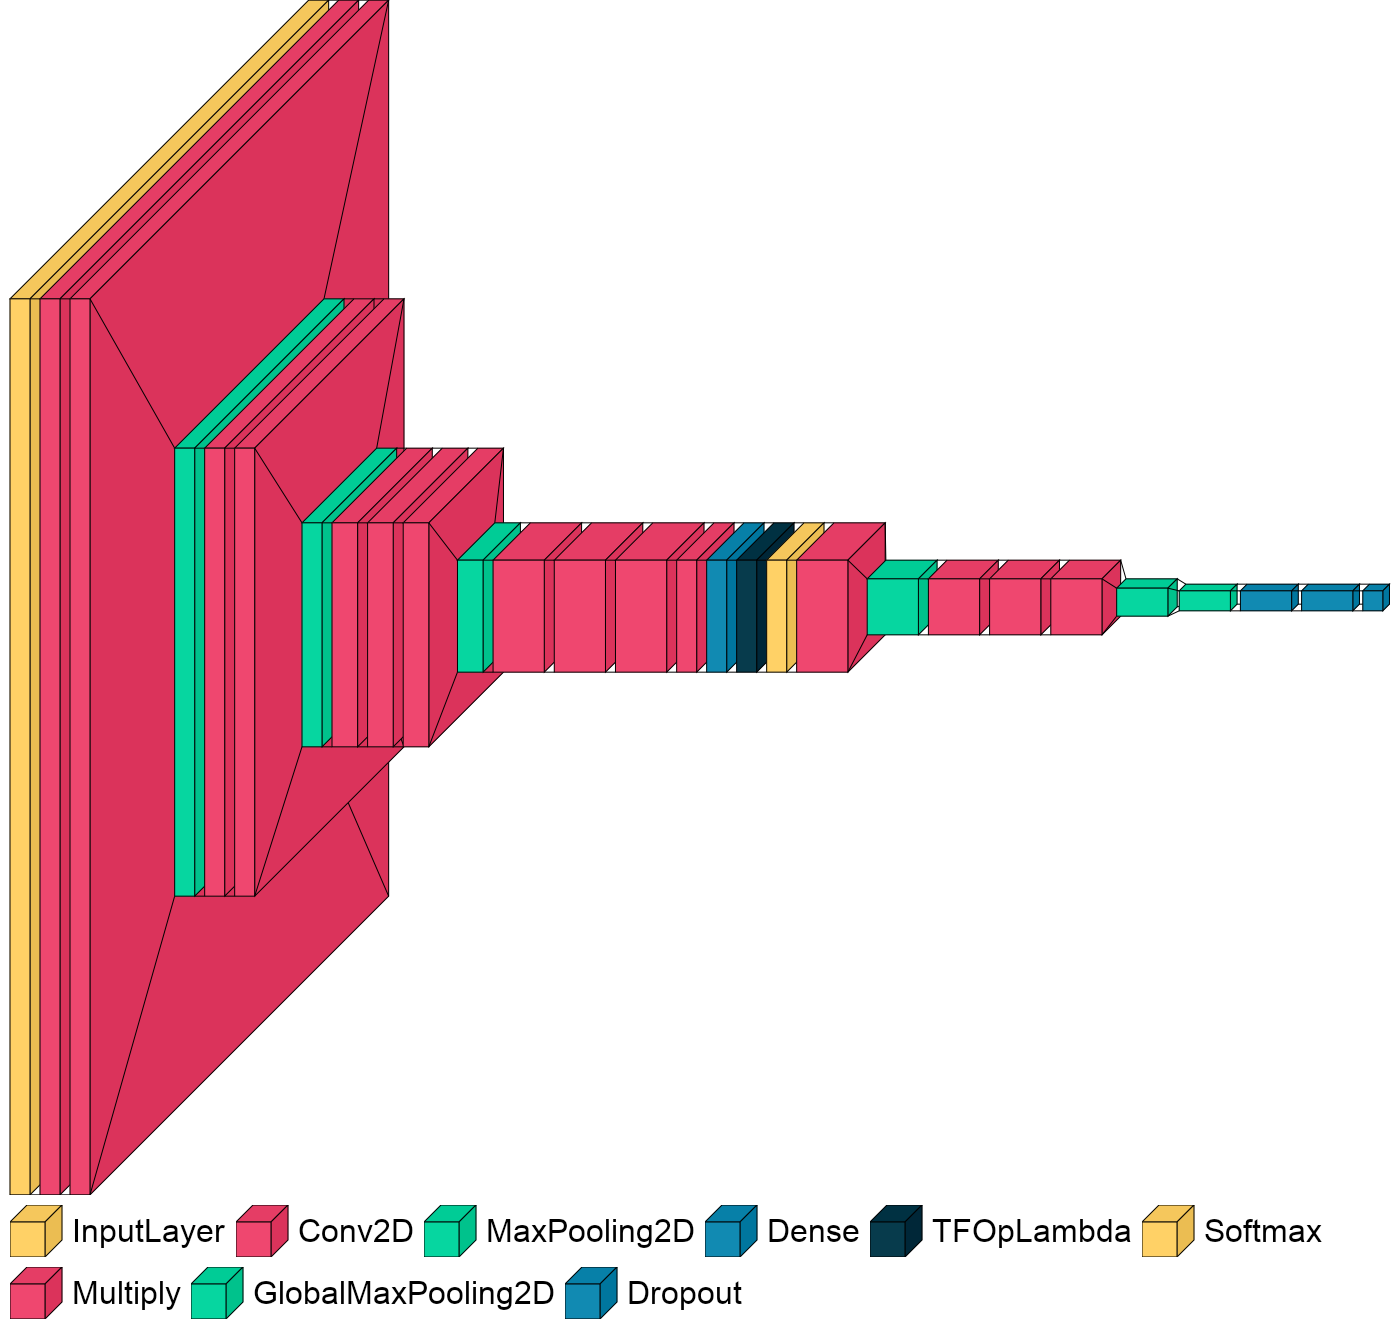

In [98]:
import tensorflow as tf
import matplotlib.pyplot as plt
from visualkeras import layered_view
from PIL import ImageFont
import PIL
import visualkeras

# Visualizza i layer del modello principale (model) con una legenda più grande
font = PIL.ImageFont.truetype("a./Arial.ttf", 32) 

print("Layers di 'model' (model):")
layered_view(model, legend=True, font=font)  # Imposta la dimensione della legenda a 18

# Visualizza i layer del modello innestato (model_4) con una legenda più grande
print("Layers di 'model_4' (model_4):")
layered_view(model.get_layer('model_4'), legend=True, font=font)  # Imposta la dimensione della legenda a 18


In [99]:
model.predict(X_val[0:1])

1/1 [==============================] - 0s 389ms/step


array([[1.3025155e-30, 7.1666049e-24, 2.8724554e-13, 7.5425981e-34,
        5.5362528e-32, 1.0000000e+00]], dtype=float32)

In [105]:
import pandas as pd

# Creare una lista vuota per contenere tutti i valori delle heatmap
all_values = []

for img, _ in zip(X_val, y_val):
    A, _ = Model(inputs=base_model.input, outputs=[attention, output])(img[None, ...])
    A = A[0, :, :, 0].numpy()
    # Aggiungi i valori della heatmap all'elenco
    all_values.extend(A.flatten())

# Specifica gli intervalli desiderati
intervals = [0, 0.1, 0.2, 0.3, 0.4, 0.5]  # Modifica questi intervalli secondo le tue esigenze

# Creare un DataFrame pandas con i valori delle heatmap
heatmap_data = pd.DataFrame({'Heatmap_Value': all_values})

# Crea una colonna con gli intervalli per ogni valore
heatmap_data['Interval'] = pd.cut(heatmap_data['Heatmap_Value'], intervals)

# Calcola la tabella di frequenza basata sugli intervalli
frequency_table = heatmap_data['Interval'].value_counts().reset_index()
frequency_table.columns = ['Intervallo', 'Frequenza']

# Visualizza la tabella di frequenza
print(frequency_table)


   Intervallo  Frequenza
0  (0.0, 0.1]     803810
1  (0.1, 0.2]        841
2  (0.2, 0.3]        241
3  (0.3, 0.4]        104
4  (0.4, 0.5]         62


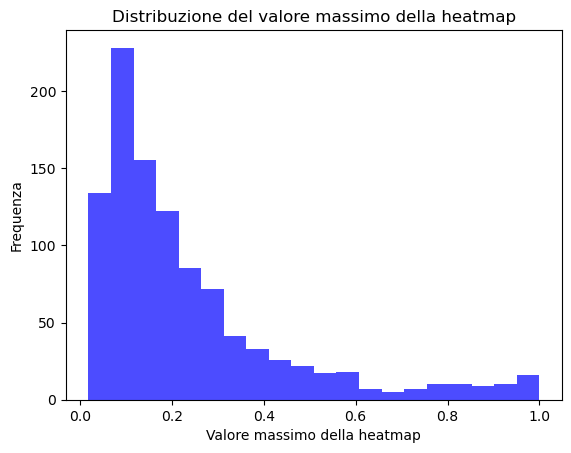

In [103]:
import matplotlib.pyplot as plt

# Creare una lista vuota per contenere i valori massimi di ciascuna heatmap
max_values = []

for img, _ in zip(X_val, y_val):
    A, _ = Model(inputs=base_model.input, outputs=[attention, output])(img[None, ...])
    A = A[0, :, :, 0].numpy()
    max_value = np.max(A)
    max_values.append(max_value)

# Istogramma dei valori massimi delle heatmap
plt.hist(max_values, bins=20, color='blue', alpha=0.7)
plt.xlabel('Valore massimo della heatmap')
plt.ylabel('Frequenza')
plt.title('Distribuzione del valore massimo della heatmap')
plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
import skimage
import numpy as np

# Directory per salvare le immagini generate
output_dir = "output_images"

# Crea la cartella se non esiste già
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Inizializza un contatore
counter = 1

for img, lab in zip(X_val, y_val):
    print(lab)
    A, pred = Model(inputs=base_model.input, outputs=[attention, output])(img[None, ...])
    print(pred[0].numpy())
    A = A[0, :, :, 0].numpy()
    A = skimage.transform.resize(A, (224, 224))

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow((img + 124)[:, :, [2, 1, 0]] / 255)
    axs[1].imshow(A)

    # Genera un nome univoco per l'immagine basato sul contatore
    output_filename = os.path.join(output_dir, f"image_{counter}_{lab}.png")
    counter += 1

    # Salva l'immagine generata nella cartella di output
    plt.savefig(output_filename)
    plt.close()


[0. 0. 0. 0. 0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3.1850914e-16 5.1494059e-08 1.3574092e-08 7.1970746e-15 1.8851500e-13
 1.0000000e+00]


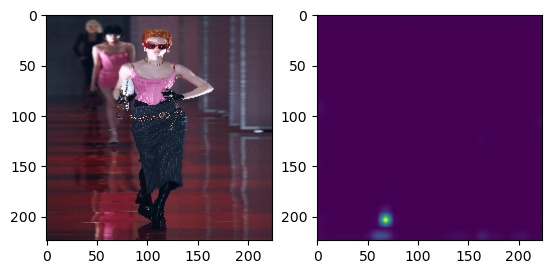

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 1. 0. 0.]
[1.1085207e-05 9.3008655e-01 5.7195401e-04 5.2040439e-02 1.6823228e-02
 4.6672267e-04]


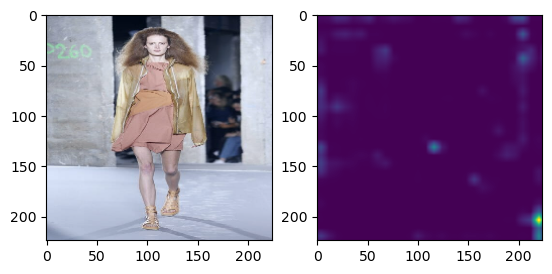

[0. 0. 1. 0. 0. 0.]
[8.9976209e-05 3.8163848e-03 9.6847320e-01 4.0403064e-04 2.5720540e-02
 1.4957413e-03]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


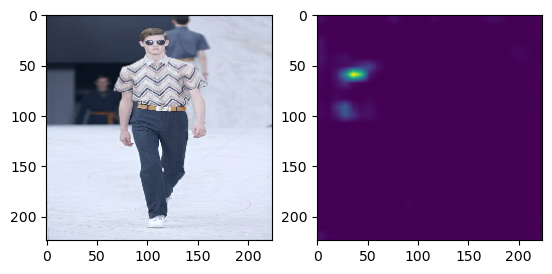

[0. 0. 1. 0. 0. 0.]
[1.2053567e-05 2.2380285e-04 7.9067826e-01 1.0871066e-08 2.0639572e-01
 2.6900724e-03]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


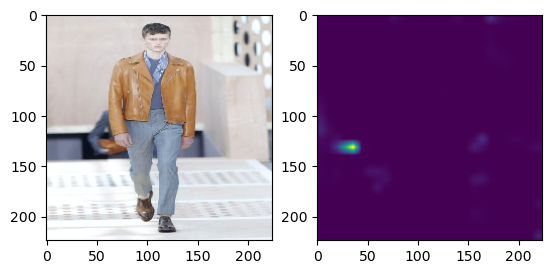

[0. 0. 1. 0. 0. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2.08728170e-06 1.53622113e-05 2.88917683e-02 1.10653655e-05
 4.68964726e-02 9.24183369e-01]


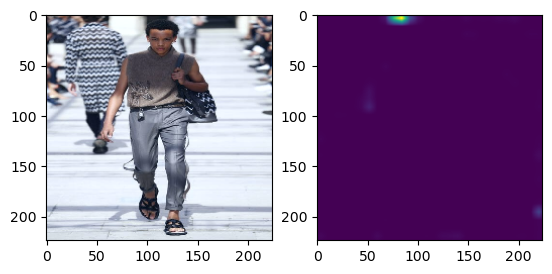

[0. 0. 0. 0. 0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2.1475629e-04 3.7951160e-02 2.7806935e-01 4.0135361e-05 2.3688008e-03
 6.8135577e-01]


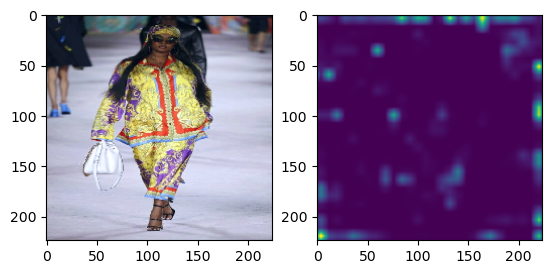

[0. 0. 0. 1. 0. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.4323102e-04 6.3548821e-01 1.2267093e-02 3.4734848e-01 3.1155956e-03
 1.6374064e-03]


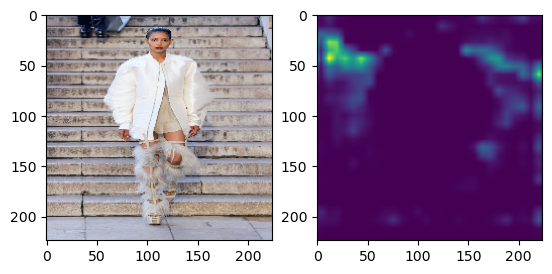

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 1. 0.]
[4.5694333e-09 3.0237803e-08 5.1793769e-09 1.4129223e-09 9.9999988e-01
 1.3635909e-07]


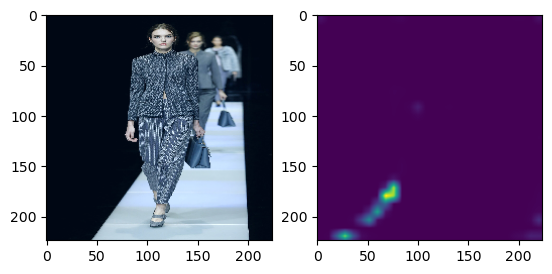

[0. 0. 0. 0. 0. 1.]
[1.2484022e-19 3.0870156e-15 2.0168487e-11 4.8662732e-12 5.7977763e-12
 1.0000000e+00]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


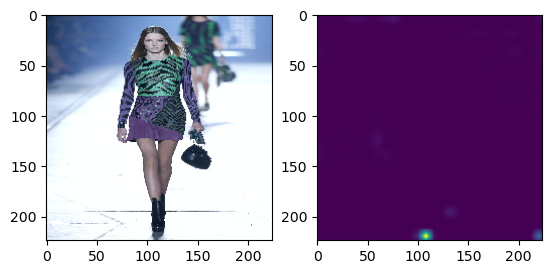

[0. 1. 0. 0. 0. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4.7166360e-08 9.9994683e-01 1.8521265e-05 2.5868228e-05 4.8538232e-07
 8.2632760e-06]


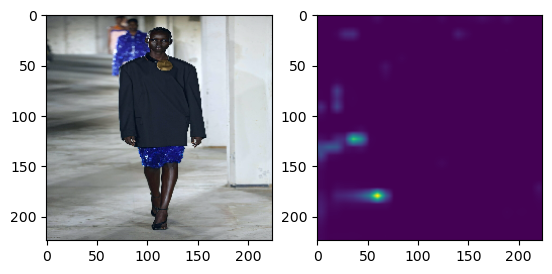

In [100]:
# attention
import matplotlib.pyplot as plt
import skimage


for img,lab in zip(X_val[:10],y_val[:10]):

    print(lab)
    A,pred = Model(inputs=base_model.input, outputs=[attention,output])(img[None,...])
    print(pred[0].numpy())
    A = A[0,:,:,0].numpy()
#     print(A.shape)
    A = skimage.transform.resize(A,(224,224))


    fig, axs = plt.subplots(1,2)
    axs[0].imshow((img+124)[:,:,[2,1,0]]/255)
    axs[1].imshow(A)
    plt.show()